<a href="https://colab.research.google.com/github/Anonymous1846/ALL-Detection-Using-CNN/blob/master/ALL_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing All The Necessary Dependancies.**

In [ ]:
#importing all the required dependencies 
#keras act as an interface for python ai(Tensorflow libs)
import keras
#validating the keras installation !
#The problem with Deep Learning is that we require a lot of data
from keras.preprocessing.image import ImageDataGenerator
#import matlabplotlib for plotting purposes !
import matplotlib.pyplot as plt
'''for building the cnn model for binary and multiple classification !
The layers for multiple layers are also imported'''
import os 
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dropout,Dense,Flatten
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from keras.preprocessing import image
print(keras.__version__)

2.4.3


# **Loading the Dataset(i.e Cancer cell images).**

In [ ]:
#the path to the cancer and normal datasets
training_data_path="/content/drive/MyDrive/Deep Learning/Datasets"
print(f'The images loaded from path :{training_data_path}')
#the training and testing data are in sepearte directories of the same driv
normal_data=os.listdir('/content/drive/MyDrive/Deep Learning/Datasets/Normal')
cancer_data=os.listdir('/content/drive/MyDrive/Deep Learning/Datasets/Blasts')
#printing the number of cancer and normal data cancer cells
print(f'The number of cancer cells : {len(cancer_data)}\nThe number of normal data : {len(normal_data)}')

The images loaded from path :/content/drive/MyDrive/Deep Learning/Datasets
The number of cancer cells : 179
The number of normal data : 155


# **Image Preprocessing**

In [ ]:
'''The image dataset contains roughly 334 images, but the main problem is that it is insufficient 
for deep learning training, so inorder to rectify that we use the ImageDataGenerator to generate 
images from the pre-exisiting images ! the below function will genearte the new images based on the paramters
provided to that function'''
training_images_preprocessed=ImageDataGenerator(rescale=1./255)


# **Applying the changes to the images from the directory !**

In [ ]:
training_images_datagen=training_images_preprocessed.flow_from_directory(
        training_data_path,  
        target_size=(200, 200),  
        batch_size=128,
        class_mode='binary')

Found 334 images belonging to 2 classes.


# **Representation of Images.**

In [ ]:
#plotting the images ! After the augemntation !


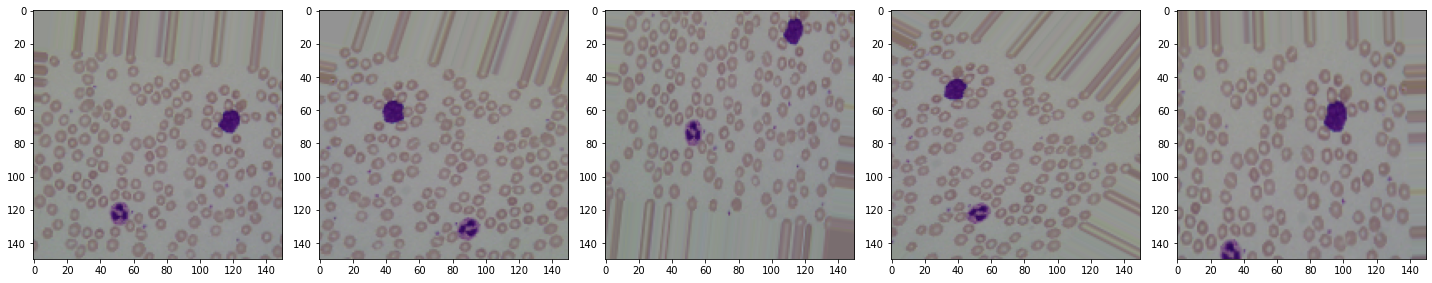

# **Building the CNN Deep Learning Model**

In [ ]:
#the classification model output will e categorical !
#list of the deep learning layers added to the model for training !
the_binary_cnn_model=Sequential([
                                    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
                                    MaxPooling2D(2, 2),
                                    # The second convolution
                                    Conv2D(32, (3,3), activation='relu'),
                                    MaxPooling2D(2,2),
                                    # The third convolution
                                    Conv2D(64, (3,3), activation='relu'),
                                    MaxPooling2D(2,2),
                                    # The fourth convolution
                                    Conv2D(64, (3,3), activation='relu'),
                                    MaxPooling2D(2,2),
                                    # The fifth convolution
                                    Conv2D(64, (3,3), activation='relu'),
                                    MaxPooling2D(2,2),
                                    # Flatten the results to feed into a DNN
                                    Flatten(),
                                    # 512 neuron hidden layer
                                    Dense(512, activation='relu'),
                                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('normal') and 1 for the other 'cancer'
                                    Dense(1, activation='sigmoid')
                                        ])

print(the_binary_cnn_model)

# **Compile the model**

In [ ]:
#applying the optimizers
#judging based on the accuracy !
the_binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# **Training the model based on the above model !**

In [ ]:
the_final_train = the_binary_cnn_model.fit(

                      training_images_datagen,
                      batch_size=10,
                      steps_per_epoch=3,  
                      epochs=60,
                      verbose=1,
                    )

Epoch 1/60


InvalidArgumentError: ignored